# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
import random
import torch.nn as nn
import time
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from maddpg import MultiAgentDDPG

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [4]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [8]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [9]:
multiagent = MultiAgentDDPG(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=10)


def maddpg(n_episodes=10000, max_t=10000):
    """Multi-Agent Deep Deterministic Policy Gradient.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    starting_time = time.time()        # for timing reasons we notice the starting time
    last_time = starting_time          # time to see how long the last hundred episodes took
    scores_record = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    max_score = -np.Inf                # initialize the maximal score to zero

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations             # get the current state
        t, scores = 0, np.zeros(num_agents)
        dones = [False for i in range(num_agents)]
        while (not np.any(dones)) and t < max_t - 1:                 # do untill done or beyond t_max
            t += 1
            actions = multiagent.act(states)                 # select an action
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations      # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done                 # see if episode has finished
            multiagent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
#             print('\rTime step {}\tAverage Score: {:.2f} \t Time passed: {:.1f} mins'.format(t, np.mean(scores_window), (time.time() - starting_time)/60.), end="")
        
        scores_window.append(np.max(scores))       # save most recent score
        scores_record.append(np.max(scores))              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f} \t Time passed: {:.1f} mins \t Steps:{}'.format(i_episode, np.mean(scores_window), (time.time() - starting_time)/60., t), end="")
        if i_episode % 100 == 0:            
            print('\rEpisode {}\tAverage Score: {:.2f} \t last 100 Episodes took {:.1f} mins \t'.format(i_episode, np.mean(scores_window), (time.time() - last_time)/60.))
            last_time = time.time()
        if np.mean(scores_window) >= max(.5, max_score + 0.1):
            print('\nNew Maximum Average Score at {:d} episodes!\tAverage Score: {:.2f} \t Time passed: {:.1f} mins'.format(i_episode, np.mean(scores_window), (time.time() - starting_time)/60.))
            #saving model
            save_dict_list =[]
            for i in range(num_agents):
                save_dict = {'actor_params' : multiagent.maddpg_agent[i].actor_local.state_dict(),
                             'actor_optim_params': multiagent.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : multiagent.maddpg_agent[i].critic_local.state_dict(),
                             'critic_optim_params' : multiagent.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)
            torch.save(save_dict_list, 'checkpoint_actors_and_critics.pth')
            max_score = np.mean(scores_window)
            print('Environment solved')
#             break
    return scores_record

In [10]:
try:
    env = UnityEnvironment(file_name='./Tennis_Linux_NoVis/Tennis.x86_64')

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    scores = maddpg()
finally:
    env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Episode 100	Average Score: 0.00 	 last 100 Episodes took 0.4 mins 	
Episode 200	Average Score: 0.00 	 last 100 Episodes took 0.4 mins 	
Episode 300	Average Score: 0.00 	 last 100 Episodes took 0.4 mins 	
Episode 400	Average Score: 0.00 	 last 100 Episodes took 0.3 mins 	
Episode 500	Average Score: 0.00 	 last 100 Episodes took 0.4 mins 	
Episode 600	Average Score: 0.00 	 last 100 Episodes took 0.4 mins 	
Episode 700	Average Score: 0.01 	 last 100 Episodes took 0.4 mins 	
Episode 800	Average Score: 0.00 	 last 100 Episodes took 0.4 mins 	
Episode 900	Average Score: 0.00 	 last 100 Episodes took 0.4 mins 	
Episode 1000	Average Score: 0.00 	 last 100 Episodes took 0.4 mins 	
Episode 1100	Average Score: 0.00 	 last 100 Episodes took 0.4 mins 	
Episode 1200	Average Score: 0.00 	 last 100 Episodes took 0.4 mins 	
Episode 1300	Average Score: 0.00 	 last 100 Episodes took 0.4 mins 	
Episode 1400	Average Score: 0.02 	 last 100 Episodes took 0.5 mins 	
Episode 1500	Average Score: 0.01 	 last 100

Episode 9400	Average Score: 0.55 	 last 100 Episodes took 5.5 mins 	441
Episode 9500	Average Score: 0.42 	 last 100 Episodes took 4.3 mins 	39
Episode 9600	Average Score: 0.75 	 last 100 Episodes took 7.8 mins 	601
Episode 9700	Average Score: 0.84 	 last 100 Episodes took 8.9 mins 	001
Episode 9800	Average Score: 0.46 	 last 100 Episodes took 4.7 mins 	821
Episode 9900	Average Score: 0.61 	 last 100 Episodes took 6.5 mins 	001
Episode 10000	Average Score: 0.91 	 last 100 Episodes took 10.1 mins 	01


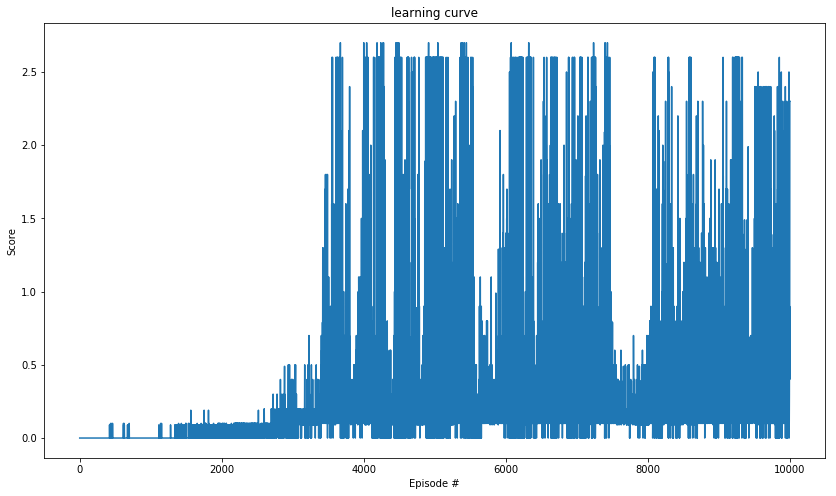

In [11]:
# plot the scores
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.title('learning curve')
plt.ylabel('Score')
plt.xlabel('Episode #')
# save the plot to a png file
plt.savefig('learning_curve.png')
plt.show()
plt.close()

### 4. The Performance of a Trained Agent

Now we look at the trained agent

In [14]:
try:
    env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    # initialize the agent
    multiagent = MultiAgentDDPG(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=10)
#     # transferlerning from saved state and set to evaluate
    save_dict = torch.load('checkpoint_actors_and_critics.pth')
    for i in range(num_agents):
        multiagent.maddpg_agent[i].actor_local.load_state_dict(save_dict[i]['actor_params'])
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    states = env_info.vector_observations             # get the current state
    t, scores = 0, np.zeros(num_agents)
    dones = [False for i in range(num_agents)]
    max_t=10000
    while (not np.any(dones)) and t < max_t - 1:                 # do untill done or beyond t_max
        t += 1
        actions = multiagent.act(states)                 # select an action
        env_info = env.step(actions)[brain_name]        # send the action to the environment
        next_states = env_info.vector_observations      # get the next state
        rewards = env_info.rewards                     # get the reward
        dones = env_info.local_done                 # see if episode has finished
        multiagent.step(states, actions, rewards, next_states, dones)
        states = next_states
        scores += rewards
    print('Total score (averaged over agents) this episode ({} steps): {}'.format(t, np.mean(scores)))

finally:
    env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Total score (averaged over agents) this episode (205 steps): 0.4950000075623393
